# Glauber on infinite random $k$-regular graph
Explore the effects of tilting the distribution by adding an external field at final time
$$
\phi_i^T(x_i^T) \propto \exp\{-\beta h^T\}
$$

In [4]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [150]:
T = 20         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

β = 1.0
J = 0.6;

In [171]:
function glauber_rrg(T, k, m⁰, β, J, h, h_final)
    wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
    ϕᵢ = map(0:T) do t
        if t == 0 
            [(1+m⁰)/2, (1-m⁰)/2]
        elseif t == T
            [exp(β*h_final), exp(-β*h_final)]
        else
            ones(2)
        end
    end
    bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
    cb = CB_BP(bp)
    
    matrix_sizes = [5, 10, 25]
    maxiters = [50, 50, 50]
    iters = zeros(Int, length(maxiters))
    tol = 1e-3
    for i in eachindex(maxiters)
        iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
    end
    
    iters_cum = cumsum(iters)
    inds = 1:iters_cum[1]
    pl_convergence = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
    for i in 2:length(iters)
        inds = iters_cum[i-1]:iters_cum[i]
       plot!(pl_convergence, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
    end
    plot!(pl_convergence, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(300,200))
    
    spin(x, i) = 3-2x
    m = only(means(spin, bp))
    
    pl_convergence, m
end;

### 1. Free dynamics

In [160]:
h = 0.0
h_final = 0.0
pl_convergence_free, magnetiz_free = glauber_rrg(T, k, m⁰, β, J, h, h_final);

Running MPBP: iter 32 	 Time: 0:09:05
  Δ:  0.0009600234219241335

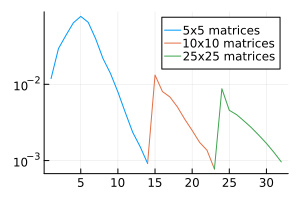

In [165]:
plot(pl_convergence_free)

### 2. Tilt with external field at final fime

In [172]:
h = 0.0
h_final = 1.0
pl_convergence_tilted, magnetiz_tilted = glauber_rrg(T, k, m⁰, β, J, h, h_final);

Running MPBP: iter 21 	 Time: 0:01:16
  Δ:  0.0005564120501360232

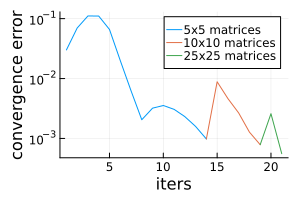

In [173]:
plot(pl_convergence_tilted)

### 3. Free dynamics ending at the same magnetization as the tilted one

In [191]:
h = 0.7
h_final = 0.0
pl_convergence_free2, magnetiz_free2 = glauber_rrg(T, k, m⁰, β, J, h, h_final);

Running MPBP: iter 7 	 Time: 0:00:04
  Δ:  3.936549850752911e-5

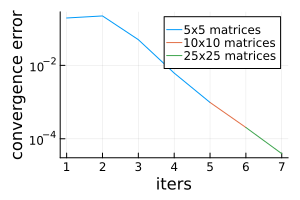

In [192]:
plot(pl_convergence_free2)

Compare

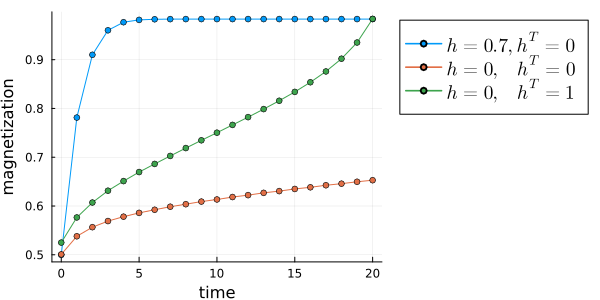

In [213]:
pl = plot(xlabel="time", ylabel="magnetization", label="", size=(600,300), xticks=0:5:T, 
    legend=:outertopright, legendfontsize=13)
plot!(pl, 0:T, magnetiz_free2, m=:o, label="\$h=0.7, h^T=0\$", ms=3)
plot!(pl, 0:T, magnetiz_free, m=:o, label="\$h=0, \\quad h^T=0\$", ms=3)
plot!(pl, 0:T, magnetiz_tilted, m=:o, label="\$h=0, \\quad h^T=1\$", ms=3)